CAVEAT: the meaning of the variables mass and radius is inverted.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import corner
import emcee
import pandas as pd
import seaborn as sns
import multiprocessing

#import jax.numpy as jnp
#from jax import jit, vmap, grad, jacfwd, hessian
#import jax.random

from analysis import *

C:\Users\gugli\AppData\Local\Temp\ipykernel_30532\4162553789.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_old = pd.read_csv(


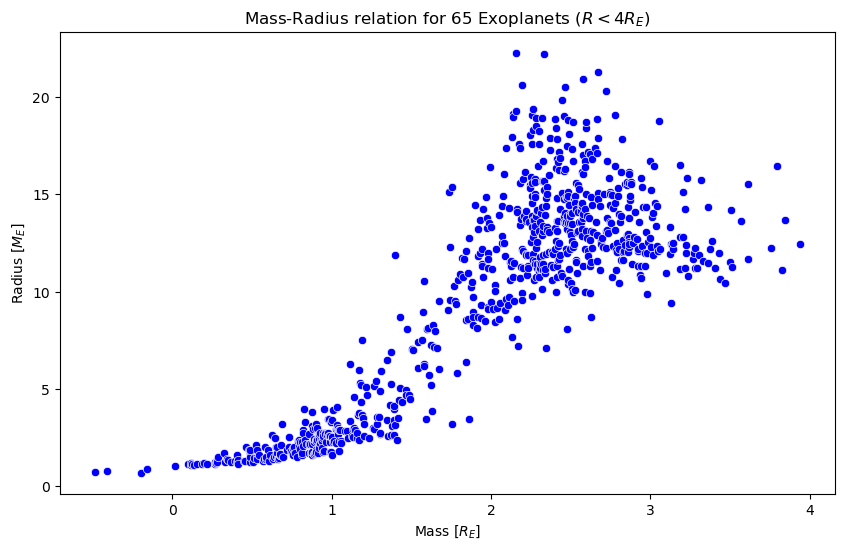

In [2]:
# Load and process the dataset
data_old = pd.read_csv(
    "DACE_Exo.csv", 
    delimiter=";", 
    dayfirst=True, 
    parse_dates=["last_updated"]
)

# Convert 'last_updated' to datetime with the specific format
data_old["last_updated"] = pd.to_datetime(data_old["last_updated"], format="%d.%m.%y", errors="coerce")

# Select relevant columns
data_new = data_old[[
    "planet_mass", "planet_mass_lower", "planet_mass_upper",
    "planet_radius", "planet_radius_lower", "planet_radius_upper",
    "discovery_year", "last_updated"
]]

# Drop rows with missing values
df = data_new.dropna()

# Ensure numeric conversion for relevant columns
cols_to_convert = ['planet_mass', 'planet_mass_lower', 'planet_mass_upper',
                   'planet_radius', 'planet_radius_lower', 'planet_radius_upper']
df.loc[:, cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Drop rows with invalid (NaN) numeric data
df = df.dropna(subset=cols_to_convert)

# Convert 'last_updated' to Unix timestamps and ensure 'ts' is an integer
df['ts'] = (df['last_updated'].astype('int64') // 10**9).astype('int64')

# Rename columns
df.rename(columns={
    'planet_radius': 'r', 'planet_radius_upper': 'r+', 'planet_radius_lower': 'r-',
    'planet_mass': 'm', 'planet_mass_upper': 'm+', 'planet_mass_lower': 'm-'
}, inplace=True)

# Drop planets released after the paper came out
df = df.drop(df[(df['ts'] >= 1688252923) & (df['discovery_year'] == 2023)].index)

# Drop unwanted columns
df = df.drop(['ts', 'discovery_year', 'last_updated'], axis=1)

# Convert to Earth Masses and Radii
df['m'], df['m-'], df['m+'] = df['m'] * 317.8284, df['m-'] * 317.8284, df['m+'] * 317.8284
df['r'], df['r-'], df['r+'] = df['r'] * 11.2089, df['r-'] * 11.2089, df['r+'] * 11.2089

# Sort by mass
df = df.sort_values('m').reset_index(drop=True)

df = df.astype(float)

# Display processed data
#print(df.head())

radius, mass, m_up, m_low, r_up, r_low = np.array(df['m']), np.array(df['r']), np.array(df['m+']), np.array(df['m-']), np.array(df['r+']), np.array(df['r-'])
#mass, radius, r_up, r_low, m_up, m_low = np.array(df['m']), np.array(df['r']), np.array(df['m+']), np.array(df['m-']), np.array(df['r+']), np.array(df['r-'])
m_err=np.concatenate((np.atleast_2d(m_low),np.atleast_2d(m_up)))
r_err=np.concatenate((np.atleast_2d(r_low),np.atleast_2d(r_up)))
sigma_mass=(r_up+r_low)/2
sigma_radius=(m_up+m_low)/2
#print(sigma_mass, sigma_radius)

sigma_radius = np.abs(sigma_radius / radius / np.log(10.0))
sigma_mass = np.abs(sigma_mass / mass / np.log(10.0))
mass = np.log10(mass)
radius = np.log10(radius)

#print(sigma_mass/mass, sigma_radius/radius)

# Plot the second column (x-axis) against the third column (y-axis)
plt.figure(figsize=(10, 6))

sns.scatterplot(x=radius, y=10**mass, marker='o', color='b')
plt.xlabel(r'Mass [$R_E$]')  # Add appropriate label for the second column
plt.ylabel(r'Radius [$M_E$]')   # Add appropriate label for the third column
plt.title(r'Mass-Radius relation for 65 Exoplanets ($R < 4R_E$)')

#plt.xscale('log')
#plt.yscale('log')

plt.show()


In [3]:
def plot_data_set(x, y, x_err=None, y_err=None):
    """Plot linear data set and format the plot."""
    fig, ax = plt.subplots(1, 1)
    if x_err is not None:
        ax.errorbar(x, y, x_err, y_err, fmt=".", label="Data")
    else:
        ax.errorbar(x, y, y_err, fmt=".", label="Data")
    ax.set_ylabel(r'Radius [$R_E$]')
    ax.set_xlabel(r'Mass [$M_E$]')
    ax.set_title(r'Mass-Radius relation for Exoplanets')
    #plt.xscale('log')
    #plt.yscale('log')
    return fig, ax

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Mass-Radius relation for Exoplanets'}, xlabel='Mass [$M_E$]', ylabel='Radius [$R_E$]'>)

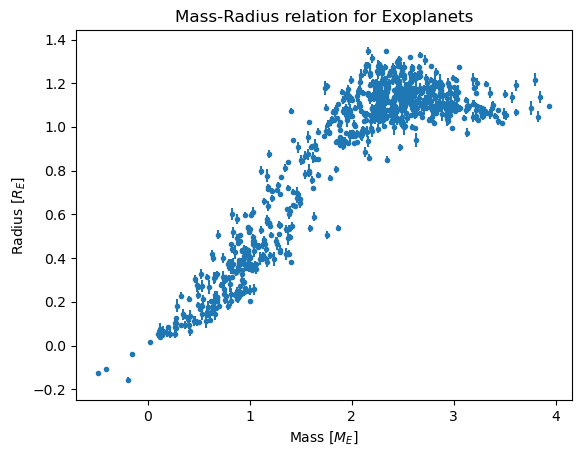

In [4]:
plot_data_set(radius, mass, None,  sigma_mass)

In [5]:
def model(theta, radius):
    #a1, b1, b2, b3  = theta
    a1, b1, b2, V1, V2 = theta

    r1 = np.log10(178.3789)
    # Combine using np.where
    return a1 + radius * b1 + np.where(radius > r1, radius - r1, 0) * b2


In [6]:
#print(radius[np.where(radius <= np.log10(178.3789))])

In [7]:
def build_likelihood():
    epsilon = 1e-8
    # Sample new data from the likelihood d -> m
    def log_likelihood(theta, x, sigma_y, y):#, sigma_pop):
        #print(len(theta))
        a1, b1, b2, V1, V2 = theta
        #a1, b1, b2, b3 = theta
        
        prediction = model(theta, x)
        residual = y - prediction
        
        #err_pop_1, err_pop_2, err_pop_3 = sigma_pop
        err_pop_1 = V1
        err_pop_2 = V2
        x = np.asarray(x)
        err_pop_list = 0
        if x.ndim == 0:
            if x <= np.log10(178.3789):
                err_pop_list = V1
            else:
                err_pop_list = V2
        else:
            x_range_1 = x[np.where(x <= np.log10(178.3789))]
            
            err_pop_list = np.zeros(len(x))
            err_pop_list[:len(x_range_1)] = err_pop_1
            err_pop_list[len(x_range_1):] = err_pop_2
    
        variance = sigma_y ** 2 + err_pop_list ** 2
    
        # Prevent division by zero or log(0)
        variance = np.where(variance == 0, 1e-12, variance)
        residual_squared = residual ** 2 / variance
    
        # Compute log-likelihood safely
        prob = -0.5 * np.sum(residual_squared) - 0.5 * np.sum(np.log(2 * np.pi * variance))
        return prob if not np.isnan(prob) else -np.inf
        
    def predict(theta, x, sigma_y):#, sigma_pop):
        #a1, b1, b2, b3 = theta
        a1, b1, b2, V1, V2 = theta
        prediction = model(theta, x)
        
        #err_pop_1, err_pop_2, err_pop_3 = sigma_pop
        err_pop_1 = V1
        err_pop_2 = V2
    
        x_range_1 = x[np.where(x <= np.log10(178.3789))]
        
        err_pop_list = np.zeros(len(x))
        err_pop_list[:len(x_range_1)] = err_pop_1
        err_pop_list[len(x_range_1):] = err_pop_2
    
        variance = sigma_y ** 2 + err_pop_list ** 2
    
        # Prevent division by zero or log(0)
        variance = np.where(variance == 0, 1e-12, variance)
        return np.random.normal(loc=prediction, scale=np.sqrt(variance))
    
    return predict, log_likelihood

In [8]:
def build_prior():
    low_a1, high_a1 = -4.0, 4.0#-0.05, 0.05
    low_b1, high_b1 = -2.0, 3.0#0.2, 0.33
    low_b2, high_b2 = -3.0, 3.0#0.3, 0.55
    low_V1, high_V1 = 0.01, 0.5#0.2, 0.33
    low_V2, high_V2 = 0.01, 0.5#0.3, 0.55
    
    def sample_from_prior(n):

        a1 = np.random.uniform(low=low_a1, high=high_a1, size=(n,))
        b1 = np.random.uniform(low=low_b1, high=high_b1, size=(n,))
        b2 = np.random.uniform(low=low_b2, high=high_b2, size=(n,))
        V1 = np.random.uniform(low=low_V1, high=high_V1, size=(n,))
        V2 = np.random.uniform(low=low_V2, high=high_V2, size=(n,))
        
        return np.stack((a1, b1, b2, V1, V2)).T

    def log_prior(theta):
        #a1, b1, b2, b3 = theta
        a1, b1, b2, V1, V2 = theta
        if (a1 < low_a1 or high_a1 < a1
        or b1 < low_b1 or high_b1 < b1
        or b2 < low_b2 or high_b2 < b2
        or V1 < low_V1 or high_V1 < V1
        or V2 < low_V2 or high_V2 < V2):
            return -np.inf
        return 0 # ignore normalisation for now HERE - Gaussian to normalize CHECK
    return sample_from_prior, log_prior

(20, 760)


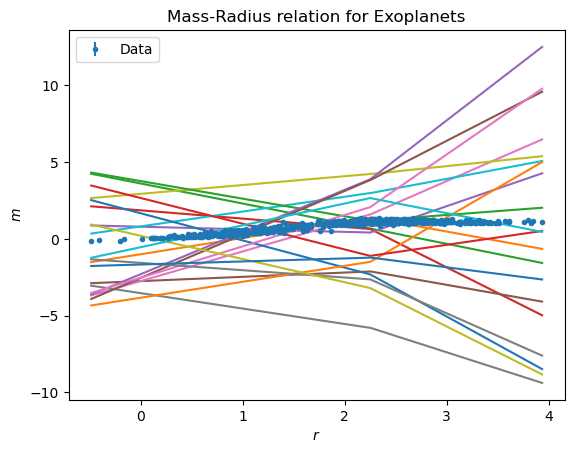

In [9]:
#V = [0.27238417, 1.7980101, 2.6342485]
#V = [0.13083392353017867, 0.48171530870285306, 0.08011670838008603]
V = [0.03880535885729321**2, 0.06428967692710091**2, 0.048234035715059485**2]

plot_data_set(radius,mass,sigma_mass)


sample_from_prior, log_prior = build_prior()

#print(sample_from_prior(n=20))

## Reproducibility
np.random.seed(42)
prior_parameters = sample_from_prior(n=20)
prior_model_predictive = np.array( [model(parameters, radius) for parameters in prior_parameters] )
print(prior_model_predictive.shape)
plt.plot(radius, prior_model_predictive[0])
plt.xlabel("$r$")
plt.ylabel("$m$")
plt.legend(loc="upper left")



plt.plot(radius , prior_model_predictive[1])
plt.plot(radius , prior_model_predictive[2])
for i in range(3,20):
    plt.plot(radius , prior_model_predictive[i])

In [10]:
sigma_pop = [0.06594285868635094, 0.11948669284789958, 0.07946499926994698]
predict, log_likelihood = build_likelihood()
print(log_likelihood((0.0, 0.3, 0.35, 0.5, 0.5),radius, sigma_mass, mass))#, sigma_pop))
#%time print(predict([0.0, 0.3, 0.35, -0.4], radius[0], sigma_mass[0], sigma_radius[0], sigma_pop))
#prior_predictive = predict() ( prior_model_predictive + err_tot*np.random.normal(size=prior_model_predictive.shape) ) ## MEAN
prior_predictive = np.empty((20, len(radius)))
#for j, parameters in enumerate(prior_parameters):
#    for i in range(len(radius)):
#        prior_predictive[j, i] = predict(parameters, radius[i], sigma_mass[i], sigma_radius[i], V) 
#print(prior_predictive.shape)
#prior_predictive = np.array( [predict(parameters, radius, sigma_mass, sigma_radius, V) for parameters in prior_parameters] )

-315.12066623987585


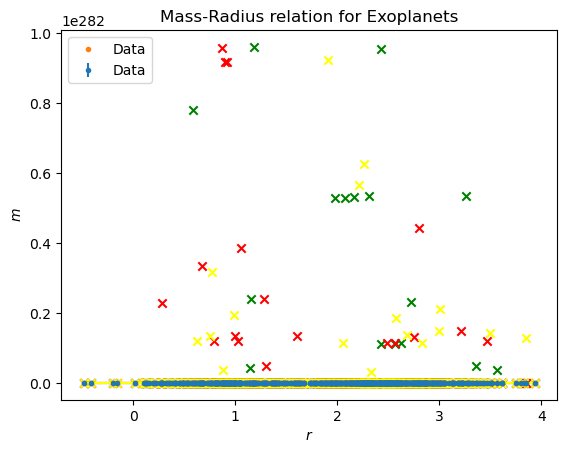

In [11]:
plot_data_set(radius, mass, sigma_mass)


plt.plot(radius, prior_model_predictive[0], marker=".", linestyle="none", label="Data")
plt.xlabel("$r$")
plt.ylabel("$m$")
plt.legend(loc="upper left")

color = ["green", "red", "yellow" ]
for i in range(3):
    plt.plot(radius , prior_model_predictive[i], color=color[i])

#############
for i in range(3):
    plt.scatter(radius, prior_predictive[i], marker='x', color=color[i])

In [12]:
def log_posterior_probability(theta, radius, sigma_mass, mass):#, sigma_pop):
    #a1, b1, b2, b3 = theta
    a1, b1, b2, V1, V2 = theta
    #return ( log_likelihood(theta, radius, sigma_mass, mass, sigma_radius, sigma_pop) + log_prior(theta) )
    return ( log_likelihood(theta, radius, sigma_mass, mass) + log_prior(theta) )

In [13]:
def negative_log_posterior(theta, radius, sigma_mass, mass):#, sigma_pop):
    #a1, b1, b2, b3 = theta
    a1, b1, b2, V1, V2 = theta
    #print("theta:", len(theta))
    return -log_posterior_probability(theta, radius, sigma_mass, mass)#, sigma_pop)
theta_init = (0.0, 0.4, -0.4, 0.15, 0.2)
#print(len(theta_init)) theta, x, sigma_y, y, sigma_x, sigma_pop
MAP_result = scipy.optimize.minimize(
        fun=negative_log_posterior,
        method="L-BFGS-B",
        x0=theta_init,
        args=(radius, sigma_mass, mass)#, sigma_pop),
    )

a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP = MAP_result.x

print("MAP results")
print(f"a1_MAP = {a1_MAP:.3f}, b1_MAP = {b1_MAP:.3f}, b2_MAP = {b2_MAP:.3f}, V1_MAP = {V1_MAP:.3f}, V2_MAP = {V2_MAP:.3f}")

MAP results
a1_MAP = -0.095, b1_MAP = 0.553, b2_MAP = -0.593, V1_MAP = 0.116, V2_MAP = 0.072


[[-3.74856651 -0.75353885 -1.26149128  0.43701569  0.40564568]
 [ 1.09128329  0.05191462 -2.03267228  0.40379932  0.44908474]
 [-1.48515215  1.77775569  2.57818591  0.10141933  0.1658217 ]
 [ 0.06856553 -0.85600917  1.84872228  0.44735391  0.06392544]
 [ 3.26053179 -1.61510045  0.80042254  0.2742777   0.12168823]]


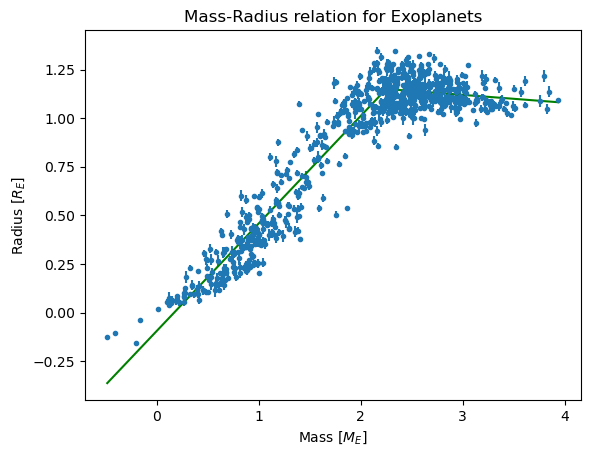

In [14]:
plot_data_set(radius, mass, sigma_mass)


plt.plot(radius, model((a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP), radius), color = "green")
#plt.plot(x, m_true*x + b_true)
#theta_init = np.array([0,0,0,0,1,2]) * np.random.normal(size=(3, 6)) # different weights
#print(theta_init)

init = sample_from_prior(5)
print(init)


In [15]:
err_pop1 = model([a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP], radius[radius <= np.log10(4.4)]) - mass[radius <= np.log10(4.4)]

# Use the correct element-wise logical operators
err_pop2 = model([a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP], radius[(radius <= np.log10(127)) & (radius > np.log10(4.4))]) - mass[(radius <= np.log10(127)) & (radius > np.log10(4.4))]

err_pop3 = model([a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP], radius[radius > np.log10(127)]) - mass[radius > np.log10(127)]

#print(err_pop1)
print(np.std(err_pop1))
print(np.std(err_pop2))
print(np.std(err_pop3))

0.08096055376826682
0.1239076685027843
0.07830950085803004


In [19]:
from emcee.moves import StretchMove

n_param = 5       # Number of parameter we are sampling
n_walker = 15     # Number of walkers. This just needs to be 
                  # larger than 2*n_param + 1!
n_step = 30000     # How many steps each walker will take. The number
                  # of samples will be n_walker*n_step

theta_init = np.array([a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP]) + np.array([0.1,0.1,0.1,0.1,0.01])* np.random.normal(size=(n_walker, n_param))
#theta_init = np.array(sample_from_prior(n_walker))

sampler = emcee.EnsembleSampler(nwalkers=n_walker, ndim=n_param, log_prob_fn=log_posterior_probability, args=(radius, sigma_mass, mass))#, sigma_pop), moves=[emcee.moves.StretchMove(a=1.9)] )
%time state = sampler.run_mcmc(theta_init, nsteps=n_step)

acceptance_rate = sampler.acceptance_fraction

# Print the acceptance rate
print(f"Acceptance rate per walker: {acceptance_rate}")
print(f"Mean acceptance rate: {acceptance_rate.mean()}")

CPU times: total: 26.6 s
Wall time: 36 s
Acceptance rate per walker: [0.55006667 0.55316667 0.55233333 0.54956667 0.5517     0.5475
 0.5507     0.55106667 0.55076667 0.54976667 0.5534     0.553
 0.54496667 0.55793333 0.5471    ]
Mean acceptance rate: 0.5508688888888889


In [20]:
print("Auto-correlation time: ")
for name, value in zip(["a1", "b1", "b2", "V1", "V2"], sampler.get_autocorr_time()):
    print(f"{name} = {value:.1f}")

chain = sampler.get_chain(discard=300, thin=10, flat=True)

Auto-correlation time: 
a1 = 64.9
b1 = 64.4
b2 = 68.2
V1 = 56.1
V2 = 62.6


(44550, 5)


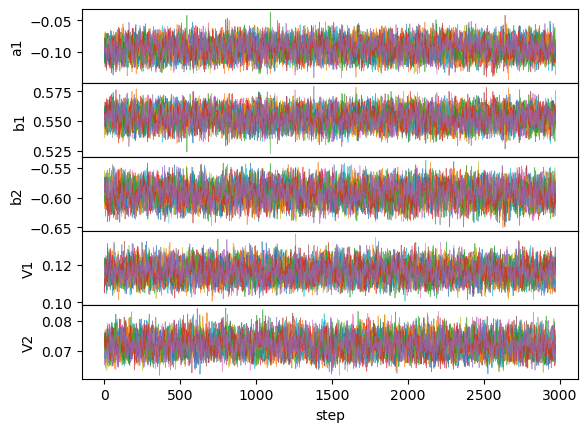

In [21]:
print(chain.shape)
chain_per_walker = sampler.get_chain(discard=300, thin=10, flat=False)
param_names = ["a1", "b1", "b2", "V1", "V2"]

# Plot the tracer of the chain, this time for all the walkers
fig, ax = plt.subplots(len(param_names), 1, sharex=True)
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walker):
        ax[i].plot(chain_per_walker[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name)

ax[-1].set_xlabel("step");  #OTHER MINIMA

In [22]:
print("Posterior results (mean±std): ")
print(f"a1 = {np.mean(chain[:,0]):.3f}±{np.std(chain[:,0]):.3f}")
print(f"b1 = {np.mean(chain[:,1]):.3f}±{np.std(chain[:,1]):.3f}")
print(f"b2 = {np.mean(chain[:,2]):.3f}±{np.std(chain[:,2]):.3f}")
print(f"V1 = {np.mean(chain[:,3]):.3f}±{np.std(chain[:,3]):.3f}")
print(f"V2 = {np.mean(chain[:,4]):.3f}±{np.std(chain[:,4]):.3f}")
# alpha1 = 10**(a1)
# beta1 = b1
# alpha2 = 10**(a1-r1*b2)
# beta2 = b1 + b2
# alpha3 = 10**(a1 - r1*b2 -r2*b3)
# beta3 = b1 + b2 + b3
alpha1 = 10**chain[:,0]
print(f"alpha1 = {np.mean(alpha1):.3f}±{np.std(alpha1):.3f}")
alpha2 = 10**(chain[:,0] - np.log10(4.4) * chain[:,2])

beta2 = chain[:,1] + chain[:,2]
print(f"beta2 = {np.mean(beta2):.4f} ± {np.std(beta2):.4f}")


print(chain.shape)

Posterior results (mean±std): 
a1 = -0.095±0.012
b1 = 0.553±0.007
b2 = -0.593±0.015
V1 = 0.116±0.004
V2 = 0.072±0.003
alpha1 = 0.805±0.023
beta2 = -0.0401 ± 0.0106
(44550, 5)


[-0.09170536  0.55097989 -0.58817718  0.11566401  0.07167688]


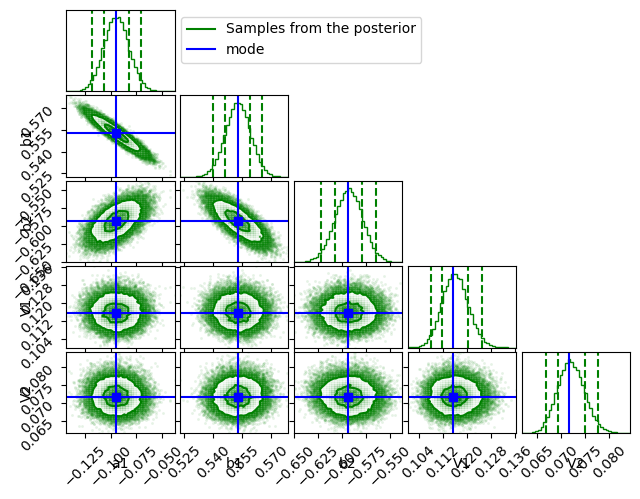

In [23]:
from scipy.stats import gaussian_kde

# Calculate the mode for each parameter in `chain`
modes = []
for i in range(chain.shape[1]):
    hist, bin_edges = np.histogram(chain[:, i], bins=40)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    max_bin_index = np.argmax(hist)
    mode_value = bin_centers[max_bin_index]
    modes.append(mode_value)

# Now calculate the 2D mode (highest density point) for the parameters

kde = gaussian_kde(chain.T)
mode_2d = chain[np.argmax(kde(chain.T)), :]
print(mode_2d)

a1_mode, b1_mode, b2_mode, V1_mode, V2_mode = mode_2d

fig = plt.figure()
fig = corner.corner(chain,
bins=40,
labels=["a1", "b1", "b2", "V1", "V2"],
color="green",
#truths=[a1_mode, b1_mode, b2_mode, b3_mode, r1_mode, r2_mode],
truths=[a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP],               
truth_color="blue",
levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding
# to 1 and 2 sigma in 2D
quantiles=[0.025, 0.16, 0.84, 0.975],
fig=fig
);
fig.get_axes()[0].plot([], [], c="green", label="Samples from the posterior")
fig.get_axes()[0].plot([], [], c="blue", label="mode")
fig.get_axes()[0].legend(loc=2, bbox_to_anchor=(1, 1))




# Add vertical lines for the modes on the diagonal plots
axes = fig.get_axes()
#for i, mode_value in enumerate(modes):
    # The diagonal plots are located at positions [0, 3, 6, ...] in a corner plot with two parameters
    #axes[i * (chain.shape[1] + 1)].axvline(mode_value, color="red", linestyle="--", label="Mode")

# Add a legend for the mode line

#axes[0].legend(loc="upper right")

plt.show()

(200, 760)


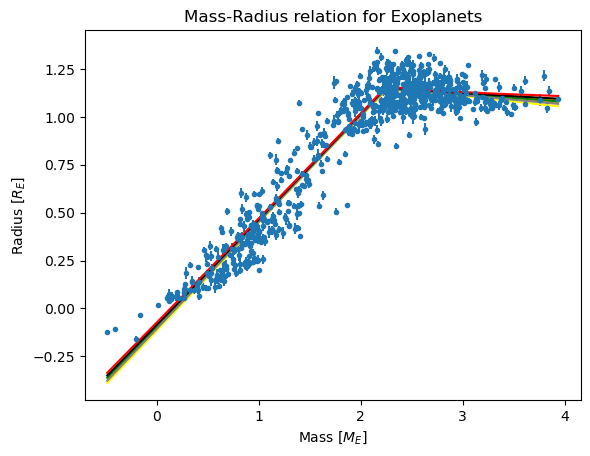

In [24]:
# CHECK

# Previous plots: 
plot_data_set(radius, mass, sigma_mass)


plt.plot(radius, model((a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP), radius), color = "green")


# Choose a small subsample of the chain for plotting purposes
chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
# Evaluate the model at the sample parameters
model_predictive = np.array( [model(sample, radius) for sample in chain_samples] )
model_quantiles = np.quantile( model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0 )
#print(model_predictive[0,:])
print(model_predictive.shape)
#print(model_quantiles)

plt.plot(radius, model_quantiles[0,:], "yellow")
plt.plot(radius, model_quantiles[1,:], color="grey")
plt.plot(radius, model_quantiles[2,:], color="black")
plt.plot(radius, model_quantiles[3,:], color="red")

plt.fill_between(radius, model_quantiles[0,:], model_quantiles[3,:],alpha=0.333, linewidth=0, color = "orange")
plt.fill_between(radius, model_quantiles[1,:], model_quantiles[2,:],alpha=0.9, linewidth=0, color = "orange")


# error on posterior not so big

In [25]:
# Get samples from the posterior predictive distribution predict(theta, x, sigma_y, sigma_x, sigma_pop)
posterior_predictive = np.array(
    [predict(sample, radius, sigma_mass) for sample in chain_samples]
)
posterior_predictive_quantiles = np.quantile(
    posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
)

theta_MAP = [a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP]

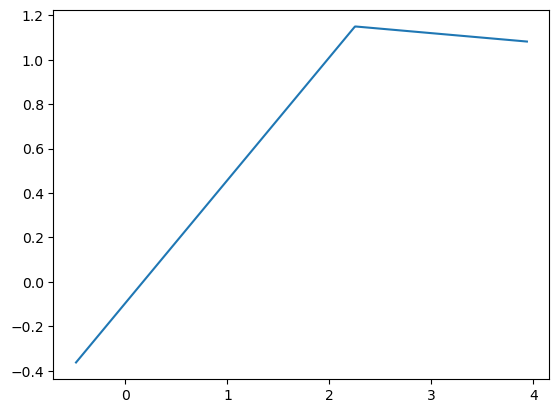

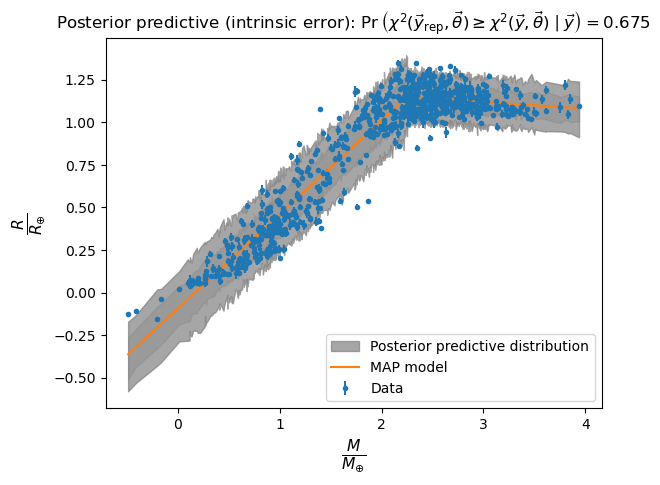

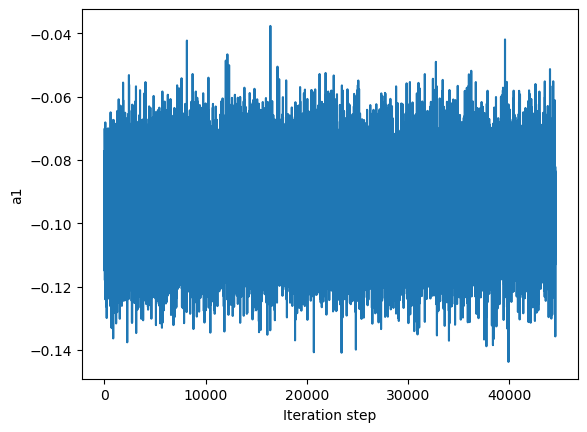

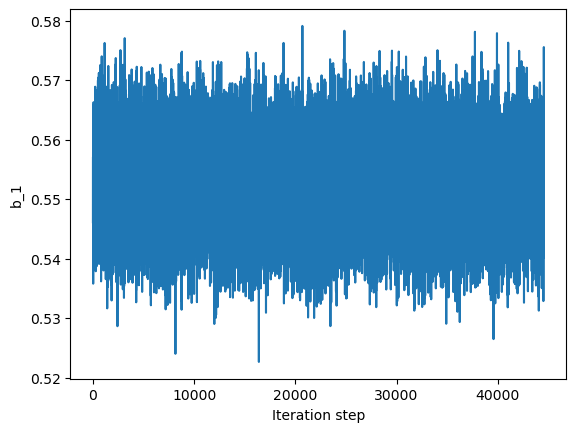

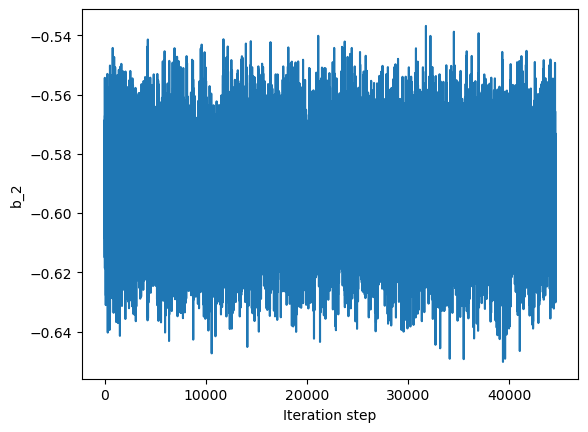

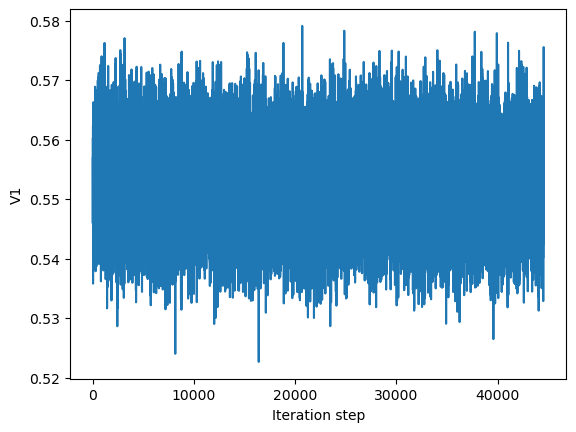

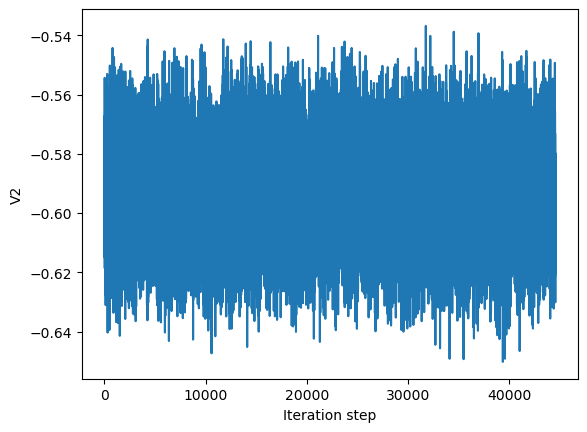

In [26]:
posterior_predictive_quantiles = np.quantile(
        posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )
plt.plot(radius,model(theta_MAP, radius),label="MAP model")
#plt.errorbar(radius,mass,sigma_radius,sigma_mass,".",label="data")
plot_data_set(radius, mass, sigma_mass)
plt.fill_between(x=radius, y1=posterior_predictive_quantiles[0], y2=posterior_predictive_quantiles[-1],
             color="grey", alpha=0.7, label="Posterior predictive distribution")
plt.fill_between(x=radius, y1=posterior_predictive_quantiles[1], y2=posterior_predictive_quantiles[-2],
             color="grey", alpha=0.3)
plt.xlabel(r"$\frac{M}{M_{\oplus}}$", color='black', fontsize=16)
plt.ylabel(r"$\frac{R}{R_{\oplus}}$", color='black', fontsize=16)
plt.title(r'Posterior predictive (intrinsic error): '
          r'$\Pr\left(\chi^2(\vec{y}_{\text{rep}}, \vec{\theta}) \geq \chi^2(\vec{y}, \vec{\theta}) \mid \vec{y}\right) = 0.675$', color='black')
plt.plot(radius, model((a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP), radius), color = "C1",label="MAP model")
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.savefig("2.png")
plt.show()

#Plot the MCMC chain
x_iter=np.arange(len(chain))
plt.plot(x_iter,chain[:,0])
plt.xlabel("Iteration step")
plt.ylabel("a1")
plt.show()

plt.plot(x_iter,chain[:,1])
plt.xlabel("Iteration step")
plt.ylabel("b_1")
plt.show()

plt.plot(x_iter,chain[:,2])
plt.xlabel("Iteration step")
plt.ylabel("b_2")
plt.show()

plt.plot(x_iter,chain[:,1])
plt.xlabel("Iteration step")
plt.ylabel("V1")
plt.show()

plt.plot(x_iter,chain[:,2])
plt.xlabel("Iteration step")
plt.ylabel("V2")
plt.show()


In [27]:
# Model check
def chi_squared(y, sigma_y, mi):
    return np.sum((y - mi)**2/sigma_y**2)

chi_squared0 = chi_squared(
    mass, sigma_mass, # If I increase error on sigma_mass we are set. This is actually the case since we are neglecting the x-axis errors.
    mi=model((a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP), radius)
)

In [28]:
n_data = len(mass)
n_param = 5

PTE = scipy.stats.chi2(df=n_data - n_param).sf(chi_squared0)


print(f"PW: χ²={chi_squared0:.1f}, "
      f"ndof={n_data}-{n_param}, PTE={PTE:.3f}")

PW: χ²=60181.6, ndof=760-5, PTE=0.000


In [29]:
def test_statistic(y, theta, x, sigma_y, model):
    #len(y)
    mi = model(theta, x)
    t = chi_squared(y, sigma_y, mi)
    return t

def ppd_model_check(test_statistic, y, ppd, ppd_params):
    t_data = []
    t_rep = []
    for y_rep, theta in zip(ppd, ppd_params):
        t_data.append(test_statistic(y, theta))
        t_rep.append(test_statistic(y_rep, theta))

    t_data = np.array(t_data)
    t_rep = np.array(t_rep)

    pte = (t_rep >= t_data).sum()/len(t_data)
    return pte, t_rep, t_data

In [30]:
PPD_PTE, t_rep, t_data = ppd_model_check(
    test_statistic=lambda y, theta: test_statistic(
        y, theta, radius, sigma_mass, model),
    y=mass,
    ppd=posterior_predictive,
    ppd_params=chain_samples
)


print(f"PPD PTE={PPD_PTE:.3f}")


PPD PTE=0.685


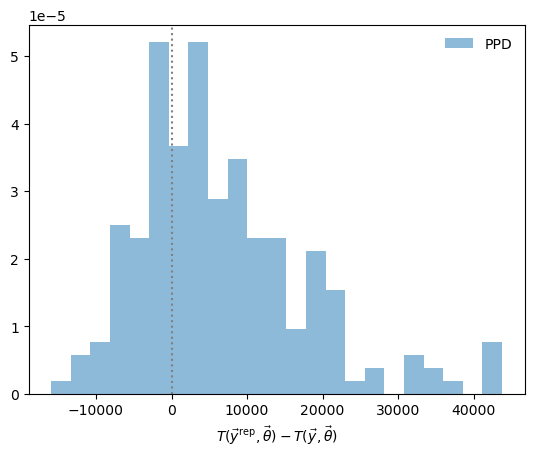

In [31]:
plt.hist(t_rep - t_data, bins=23, density=True, alpha=0.5, label="PPD")
plt.axvline(0, ls=":", color="grey")
plt.legend(frameon=False)
plt.xlabel(r"$T(\vec y^\mathrm{rep}, \vec\theta) - T(\vec y, \vec\theta)$");

In [32]:
def DIC(theta_star, theta_samples, log_likelihood):
    # Compute log likelihood at theta_star and the samples theta_i
    log_likelihood_star = log_likelihood(theta_star)
    log_likelihood_samples = np.array(
        [log_likelihood(theta) for theta in theta_samples]
    )
    p_D = 2*(log_likelihood_star - np.mean(log_likelihood_samples))
    p_V = 2*np.var(log_likelihood_samples)
    return -2*(log_likelihood_star - p_D), p_D, p_V

In [33]:
theta_MAP2 = np.array([a1_MAP, b1_MAP, b2_MAP, V1_MAP, V2_MAP])#log_likelihood(theta, radius, sigma_mass, mass, sigma_radius)

DIC2, p_D2, p_V2 = DIC(
    theta_star=theta_MAP2,
    theta_samples=chain_samples, 
    log_likelihood=lambda theta: log_likelihood(theta, radius, sigma_mass, mass)
)

print(f"2: DIC = {DIC2:.1f}, p_D = {p_D2:.1f}, p_V = {p_V2:.1f}")

2: DIC = -1441.3, p_D = 5.0, p_V = 4.8


In [34]:
def BIC(theta_star, log_likelihood, n_data, k_params):
    """
    Compute the Bayesian Information Criterion (BIC).

    Parameters:
        theta_star (array): MAP estimate of the parameters.
        log_likelihood (function): Log-likelihood function.
        n_data (int): Number of data points.
        k_params (int): Number of parameters in the model.

    Returns:
        float: BIC value.
    """
    log_likelihood_star = log_likelihood(theta_star)
    bic = -2 * log_likelihood_star + k_params * np.log(n_data)
    return bic

In [35]:
n_data = len(radius)
BIC_value = BIC(
    theta_star=theta_MAP2,
    log_likelihood=lambda theta: log_likelihood(theta, radius, sigma_mass, mass),
    n_data=n_data,
    k_params=5
)

print(f"BIC = {BIC_value:.1f}")

BIC = -1418.1


In [36]:
def WAIC(theta_samples, log_likelihood, y_partitions, x_partitions, y_err_partitons):
    # Compute the log likelihood for each partition separately
    pointwise_log_likelihood_samples = np.array(
        [[log_likelihood(theta, x_partitions[i], y_err_partitons[i], y_partitions[i])
            for i in range(len(y_partitions))] 
         for theta in theta_samples]
    )

    # Compute the lppd and p_waic for each partition
    lppd = np.log(np.mean(np.exp(pointwise_log_likelihood_samples), axis=0))
    p_waic = np.var(pointwise_log_likelihood_samples, axis=0)
    # Check if the any of the terms in p_waic are too large, which indicates
    # a problem
    if np.any(p_waic > 0.4):
        print(f"Warning: Var[log p(y_i|theta)] > 0.4 for data points "
              f"{np.argwhere(p_waic > 0.4)}. p_WAIC unreliable!")
    # Sum up the partitions
    lppd = np.sum(lppd)
    p_waic = np.sum(p_waic)

    return -2*(lppd - p_waic), p_waic, pointwise_log_likelihood_samples

In [37]:
WAIC, p_WAIC, pointwise_log_likelihood_samples = WAIC(
    theta_samples=chain_samples,
    log_likelihood=log_likelihood,
    y_partitions=mass,
    x_partitions=radius,
    y_err_partitons=sigma_mass
)

print(f"2: WAIC = {WAIC:.1f}, p_WAIC = {p_WAIC:.1f}")

2: WAIC = -1441.2, p_WAIC = 4.9


In [31]:
# 2 PIECES
# 2 PIECES
# 2 PIECES
# 2 PIECES
# 2 PIECES
# 2 PIECES
# 2 PIECES
# 2 PIECES
# 2 PIECES
# 2 PIECES

In [32]:
def model2(theta, r):
    a1, b1, b2, r1 = theta  # Removed parameters for r2, b3, and a3



    # Define the two power laws
    #f1 = a1 + b1 * r_safe
    #f2 = b2 * (r_safe - r1) + b1 * r1 + a1

    # Combine using np.where with a single non-smoothness point at r1
    #f = np.where(r_safe <= r1, f1, f2)

    return a1 + r * b1 + np.where(r > r1, r - r1, 0) * b2



In [33]:
def propagate_mass_error2(theta, r, sigma_radius, mass):

    a1, b1, b2, r1 = theta

    dy_dr = (
        b1 
        + np.where(r > r1, b2, 0) 
    )
    # Propagate the error in radius to the function
    #sigma_f = np.abs(err) * sigma_radius

    # Compute the propagated error on mass
    # Assuming mass = f(r) (simplified relation for propagation purposes)
    sigma_mass = np.abs(dy_dr) * sigma_radius  # If mass is directly proportional to f(r)

    return sigma_mass
#theta = [0.2,0.3,0.5,0.7,5.0]
#print(model(theta, 10))
#print(propagate_mass_error(theta,10,0.1,0.45839090779846564))

In [34]:
def build_likelihood2():
    # Sample new data from the likelihood d -> m
    def predict2(theta, radius, sigma_mass, sigma_radius, mass):
        mi = model2(theta, radius)  # Compute model prediction
        a1, b1, b2, r1 = theta
        err_tot = 1*np.sqrt(sigma_mass**2 + (propagate_mass_error2(theta, radius, sigma_radius, mass))**2)
        err_tot = np.maximum(err_tot, 1e-8)  # Prevent division by zero
        return np.random.normal(loc=mi, scale=err_tot)  # Sample from Gaussian distribution

    # Evaluate the log-likelihood HERE
    def log_likelihood2(mass, theta, radius, sigma_mass, sigma_radius):
        mi = model2(theta, radius)  # Model prediction
        n = len(mass)
        a1, b1, b2, r1 = theta
        err_tot = 1*np.sqrt(sigma_mass**2 + (propagate_mass_error2(theta, radius, sigma_radius, mass))**2)
        err_tot = np.maximum(err_tot, 1e-8)  # Prevent division by zero

        # Calculate the log-likelihood
        log_likelihood_value = (
            -0.5 * np.sum((mass - mi)**2 / err_tot**2)    # Exponent part
            -0.5 * np.sum(np.log(2 * np.pi * err_tot**2))  # Normalization part
        )
        
        return log_likelihood_value
    
    return predict2, log_likelihood2

In [35]:
def build_prior2():
    low_a1, high_a1 = -0.5, 0.5
    low_b1, high_b1 = 0.2, 0.9
    low_b2, high_b2 = -0.75, -0.0001
    low_r1, high_r1 = 1.8,2.5
    def sample_from_prior2(n):
        a1 = np.random.uniform(low=low_a1, high=high_a1, size=(n,))
        b1 = np.random.uniform(low=low_b1, high=high_b1, size=(n,))
        b2 = np.random.uniform(low=low_b2, high=high_b2, size=(n,))
        r1 = np.random.uniform(low=low_r1, high=high_r1, size=(n,))
        return np.stack((a1, b1, b2, r1)).T
    def log_prior2(theta):
        a1, b1, b2, r1 = theta
        if (a1 < low_a1 or high_a1 < a1
        or b1 < low_b1 or high_b1 < b1
        or b2 < low_b2 or high_b2 < b2
        or r1 < low_r1 or high_r1 < r1):
            return -np.inf
        # Compute the normalization constant for each uniform prior
        norm_a1 = 1 / (high_a1 - low_a1)
        norm_b1 = 1 / (high_b1 - low_b1)
        norm_b2 = 1 / (high_b2 - low_b2)
        norm_r1 = 1 / (high_r1 - low_r1)
        
        # The log prior is the sum of the logs of the individual uniform priors
        log_prior_value = np.log(norm_a1) + np.log(norm_b1) + np.log(norm_b2) + np.log(norm_r1)
        
        return log_prior_value
    return sample_from_prior2, log_prior2

In [ ]:
plot_data_set(radius,mass,sigma_mass)


sample_from_prior2, log_prior2 = build_prior2()

#print(sample_from_prior(n=20))

## Reproducibility
np.random.seed(42)
prior_parameters2 = sample_from_prior2(n=20)
prior_model_predictive2 = np.array( [model2(parameters, radius) for parameters in prior_parameters2] )
print(prior_parameters2.shape)
plt.plot(radius, prior_model_predictive2[0])
plt.xlabel("$r$")
plt.ylabel("$m$")
plt.legend(loc="upper left")



plt.plot(radius , prior_model_predictive2[1])
plt.plot(radius , prior_model_predictive2[2])
for i in range(3,20):
    plt.plot(radius , prior_model_predictive2[i])

In [ ]:
# Since we have a Gaussian likelihood, we can add Gaussian noise with the 
# correct variance to our prior model predictions
#b_samples = prior_parameters[:,1] # Shape (20)
#print(b_samples)


n_rows = len(prior_parameters2[:,0])
n_cols = len(radius)
err_tot = np.zeros((n_rows, n_cols))
for i in range(n_rows):
    theta = [prior_parameters2[i,0], prior_parameters2[i,1],prior_parameters2[i,2], prior_parameters2[i,3]]
    for j in range(n_cols):
        err_tot[i,j] = np.sqrt(sigma_mass[j]**2 + (propagate_mass_error2(theta, radius[j], sigma_radius[j], prior_model_predictive2[i,j]))**2)
#err_tot = np.sqrt(sigma_mass**2 + (prior_model_predictive*b_samples*sigma_radius/radius)**2)
# Check the shape of the result

#print(err_tot.shape)  # Should output (20, 65)  (prior_model_predictive[i,j]*b_samples[i]*sigma_radius[j]/radius[j])**2

prior_predictive2 = ( prior_model_predictive2 + err_tot*np.random.normal(size=prior_model_predictive2.shape) ) ## MEAN

print(prior_model_predictive2.shape)

In [ ]:
plot_data_set(radius, mass, sigma_mass)


plt.plot(radius, prior_model_predictive2[0], marker=".", linestyle="none", label="Data")
plt.xlabel("$r$")
plt.ylabel("$m$")
plt.legend(loc="upper left")

color = ["green", "red", "yellow" ]
for i in range(3):
    plt.plot(radius , prior_model_predictive2[i], color=color[i])

#############
for i in range(3):
    plt.scatter(radius, prior_predictive2[i], marker='x', color=color[i])

In [39]:
# FIT
predict2, log_likelihood2 = build_likelihood2()


def log_posterior_probability2(theta, radius, sigma_mass, mass, sigma_radius):
    a1, b1, b2, r1 = theta
    return ( log_likelihood2(mass, theta, radius, sigma_mass, sigma_radius) + log_prior2(theta) )

In [ ]:
# The scipy minimizer finds the minimum, so we need to take the 
# negative of the posterior. The scipy minimizer also passes an array 
# with the parameters, this wrapper splits this array into m and b.
def negative_log_posterior2(theta, radius, sigma_mass, mass, sigma_radius):
    a1, b1, b2, r1 = theta
    return -log_posterior_probability2(theta, radius, sigma_mass, mass, sigma_radius)


MAP_result2 = scipy.optimize.minimize(
    fun=lambda theta: -log_posterior_probability2(theta=theta, radius=radius,
    sigma_mass=sigma_mass, mass=mass, sigma_radius=sigma_radius),
    x0=(-0.1, 0.4, -0.75, 2.0)
    ) # theta is the variable in function of which we want minimize
a1_MAP2, b1_MAP2, b2_MAP2, r1_MAP2 = MAP_result2.x
#m_true = 1.3
#b_true = -0.2
print("MAP results")
print(f"a1_MAP = {a1_MAP2:.3f}, b1_MAP = {b1_MAP2:.3f}, b2_MAP = {b2_MAP2:.3f}, r1_MAP = {r1_MAP2:.3f}")
#print(f"m_true = {m_true:.3f}, b_true = {b_true:.3f}")


In [ ]:
plot_data_set(radius, mass, sigma_mass)


plt.plot(radius, model2((a1_MAP2, b1_MAP2, b2_MAP2, r1_MAP2), radius), color = "green")
#plt.plot(x, m_true*x + b_true)
#theta_init = np.array([0,0,0,0,1,2]) * np.random.normal(size=(3, n_param)) # different weights
#print(theta_init)

In [ ]:
from emcee.moves import StretchMove

# emcee passes an array of values for the sampled parameters
# This wrapper just splits the array theta into m and b

# emcee requires some extra settings to run
n_param = 4       # Number of parameter we are sampling
n_walker = 20     # Number of walkers. This just needs to be 
                  # larger than 2*n_param + 1!
n_step = 100000     # How many steps each walker will take. The number
                  # of samples will be n_walker*n_step

#red_blue_move = emcee.moves.RedBlueMove(nsplits=2, randomize_split=True, live_dangerously=True)

# The starting point for each walker


#with multiprocessing.Pool() as pool:
    # Define theta_init and the sampler
#    theta_init = np.array([a1_MAP, b1_MAP, a2_MAP, b2_MAP, rc_MAP]) + 0.3 * np.random.normal(size=(n_walker, n_param))
#    sampler = emcee.EnsembleSampler(
#        nwalkers=n_walker, ndim=n_param, log_prob_fn=log_posterior_probability, args=(radius, sigma_mass, mass), pool=pool, moves=(emcee.moves.RedBlueMove(nsplits=2.5, randomize_split=True, live_dangerously=True))
#    )
    # Run MCMC, emcee.moves.RedBlueMove(nsplits=2, randomize_split=True, live_dangerously=False) , emcee.moves.StretchMove(a=2.5)
#    %time state = sampler.run_mcmc(theta_init, nsteps=n_step)

theta_init = np.array([a1_MAP2, b1_MAP2, b2_MAP2, r1_MAP2]) + np.array([0.01,0.01,0.01,0.01])* np.random.normal(size=(n_walker, n_param)) # different weights
sampler = emcee.EnsembleSampler(nwalkers=n_walker, ndim=n_param, log_prob_fn=log_posterior_probability2, args=(radius, sigma_mass, mass, sigma_radius), moves=[emcee.moves.StretchMove(a=2.5)] )
%time state = sampler.run_mcmc(theta_init, nsteps=n_step)

acceptance_rate = sampler.acceptance_fraction

# Print the acceptance rate
print(f"Acceptance rate per walker: {acceptance_rate}")
print(f"Mean acceptance rate: {acceptance_rate.mean()}")

In [ ]:
# The samples will be correlated, this checks how correlated they are
# We will discuss this once we come to MCMC methods
print("Auto-correlation time: ")
for name, value in zip(["a1", "b1", "b2", "b3", "r1"], sampler.get_autocorr_time()):
    print(f"{name} = {value:.1f}")
# We need to discard the beginning of the chain (a few auto-correlation times)
# to get rid of the initial conditions
chain2 = sampler.get_chain(discard=500, thin=10, flat=True) #THIN

In [ ]:
print(chain2.shape)
chain_per_walker2 = sampler.get_chain(discard=300, thin=10, flat=False) #THIN
param_names = ["a1", "b1", "b2", "r1"]

# Plot the tracer of the chain, this time for all the walkers
fig, ax = plt.subplots(len(param_names), 1, sharex=True)
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walker):
        ax[i].plot(chain_per_walker2[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name)

ax[-1].set_xlabel("step");  #OTHER MINIMA

In [ ]:
print("Posterior results (mean±std): ")
print(f"a1 = {np.mean(chain2[:,0]):.3f}±{np.std(chain2[:,0]):.3f}")
print(f"b1 = {np.mean(chain2[:,1]):.3f}±{np.std(chain2[:,1]):.3f}")
print(f"b2 = {np.mean(chain2[:,2]):.3f}±{np.std(chain2[:,2]):.3f}")
print(f"r1 = {np.mean(chain2[:,3]):.3f}±{np.std(chain2[:,3]):.3f}")

# alpha1 = 10**(a1)
# beta1 = b1
# alpha2 = 10**(a1-r1*b2)
# beta2 = b1 + b2
# alpha3 = 10**(a1 - r1*b2 -r2*b3)
# beta3 = b1 + b2 + b3
alpha1 = 10**chain[:,0]
print(f"alpha1 = {np.mean(alpha1):.3f}±{np.std(alpha1):.3f}")
alpha2 = 10**(chain[:,0] - chain[:,3] * chain[:,2])
print(f"alpha2 = {np.mean(alpha2):.3f}±{np.std(alpha2):.3f}")



print(chain2)

In [ ]:
from scipy.stats import gaussian_kde

# Calculate the mode for each parameter in `chain`
modes = []
for i in range(chain2.shape[1]):
    hist, bin_edges = np.histogram(chain2[:, i], bins=40)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    max_bin_index = np.argmax(hist)
    mode_value = bin_centers[max_bin_index]
    modes.append(mode_value)

# Now calculate the 2D mode (highest density point) for the parameters

kde = gaussian_kde(chain2.T)
mode_2d = chain[np.argmax(kde(chain2.T)), :]
print(mode_2d)

a1_mode, b1_mode, b2_mode, r1_mode = mode_2d

fig = plt.figure()
fig = corner.corner(chain2,
bins=40,
labels=["a1", "b1", "b2", "r1"],
color="green",
truths=[a1_mode, b1_mode, b2_mode, r1_mode],
truth_color="blue",
levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding
# to 1 and 2 sigma in 2D
quantiles=[0.025, 0.16, 0.84, 0.975],
fig=fig
);
fig.get_axes()[0].plot([], [], c="green", label="Samples from the posterior")
fig.get_axes()[0].plot([], [], c="blue", label="2d mode")
fig.get_axes()[0].legend(loc=2, bbox_to_anchor=(1, 1))




# Add vertical lines for the modes on the diagonal plots
axes = fig.get_axes()
#for i, mode_value in enumerate(modes):
    # The diagonal plots are located at positions [0, 3, 6, ...] in a corner plot with two parameters
    #axes[i * (chain.shape[1] + 1)].axvline(mode_value, color="red", linestyle="--", label="Mode")

# Add a legend for the mode line

#axes[0].legend(loc="upper right")

plt.show()

In [ ]:
# CHECK

# Previous plots: 
plot_data_set(radius, mass, sigma_mass)


plt.plot(radius, model2((a1_MAP2, b1_MAP2, b2_MAP2, r1_MAP2), radius), color = "green")


# Choose a small subsample of the chain for plotting purposes
chain_samples2 = chain2[np.random.choice(chain.shape[0], size=200)]
# Evaluate the model at the sample parameters
model_predictive = np.array( [model2(sample, radius) for sample in chain_samples2] )
model_quantiles = np.quantile( model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0 )
print(model_predictive[0,:])
print(model_predictive.shape)
#print(model_quantiles)

plt.plot(radius, model_quantiles[0,:], "yellow")
plt.plot(radius, model_quantiles[1,:], color="grey")
plt.plot(radius, model_quantiles[2,:], color="black")
plt.plot(radius, model_quantiles[3,:], color="red")

plt.fill_between(radius, model_quantiles[0,:], model_quantiles[3,:],alpha=0.333, linewidth=0, color = "orange")
plt.fill_between(radius, model_quantiles[1,:], model_quantiles[2,:],alpha=0.9, linewidth=0, color = "orange")


# error on posterior not so big

In [ ]:
# Since we have a Gaussian likelihood, we can add Gaussian noise with the 
# correct variance to our prior model predictions
#b_samples = prior_parameters[:,1] # Shape (20)
#print(b_samples)


n_rows = len(chain_samples2[:,0])
n_cols = len(radius)
err_tot = np.zeros((n_rows, n_cols))
for i in range(n_rows):
    theta = [chain_samples2[i,0], chain_samples2[i,1],chain_samples2[i,2],chain_samples2[i,3]]
    for j in range(n_cols):
        err_tot[i,j] = np.sqrt(sigma_mass[j]**2 + (propagate_mass_error2(theta, radius[j], sigma_radius[j], model_predictive[i,j]))**2)
#err_tot = np.sqrt(sigma_mass**2 + (prior_model_predictive*b_samples*sigma_radius/radius)**2)
# Check the shape of the result

#print(err_tot.shape)  # Should output (20, 65)  (prior_model_predictive[i,j]*b_samples[i]*sigma_radius[j]/radius[j])**2

posterior_predictive2 = ( model_predictive + err_tot*np.random.normal(size=model_predictive.shape) ) ## MEAN

print(model_predictive.shape)

In [ ]:
radius = np.array(radius)
"""
print(type(radius))
print(radius, np.shape(radius)) # 65
print(posterior_predictive, np.shape(posterior_predictive)) # (200, 65)
"""

fig, ax = plt.subplots(figsize=(33, 5.5))

# Create the violin plot
violin_parts = ax.violinplot(posterior_predictive2, positions=radius, showmeans=False, showmedians=False, widths=0.1)

# Customize the appearance of the violins
for partname in ('cbars','cmins','cmaxes'):
    vp = violin_parts[partname]
    vp.set_edgecolor('gray')
    vp.set_linewidth(1.5)

# Change the colors of the violins
for pc in violin_parts['bodies']:
    pc.set_facecolor('skyblue')  # Change the color of the violins
    pc.set_edgecolor('black')  # Set the border color
    pc.set_alpha(0.3)  # Set transparency

# Add axis labels and a title
ax.set_xlabel(r'Radius [$R_E$]')
ax.set_ylabel(r'Mass [$M_E$]')
ax.set_title("Posterior Predictive Distribution", fontsize=14)

# Show gridlines
ax.grid(True)

# Add a legend or labels
ax.legend(['Samples from posterior'], loc='upper left')

# Previous plots: 
ax.errorbar(radius, mass, sigma_mass, fmt=".", label="Data")

plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.savefig("violin.png")
plt.show()

In [36]:
# Model check
def chi_squared(y, sigma_y, mi):
    return np.sum((y - mi)**2/sigma_y**2)

#chi_squared2 = chi_squared(
#    mass, sigma_mass, # If I increase error on sigma_mass we are set. This is actually the case since we are neglecting the x-axis errors.
#    mi=model2((a1_MAP2, b1_MAP2, b2_MAP2, r1_MAP2), radius)
#)

chi_squared = chi_squared(
    mass, sigma_mass, # If I increase error on sigma_mass we are set. This is actually the case since we are neglecting the x-axis errors.
    mi=model((a1_MAP, b1_MAP, b2_MAP, b3_MAP), radius)
)
# MAP and mean of chain

In [37]:
n_data = len(mass)
n_param = 4
n_param2 = 4


PTE = scipy.stats.chi2(df=n_data - n_param).sf(chi_squared)


print(f"PW: χ²={chi_squared:.1f}, "
      f"ndof={n_data}-{n_param}, PTE={PTE:.3f}")

#PTE2 = scipy.stats.chi2(df=n_data - n_param2).sf(chi_squared2)


#print(f"PW: χ²={chi_squared2:.1f}, "
#      f"ndof={n_data}-{n_param2}, PTE={PTE2:.3f}")

PW: χ²=56986.1, ndof=760-4, PTE=0.000


In [32]:
def test_statistic(y, theta, x, sigma_y, model):
    len(y)
    mi = model(theta, x)
    t = chi_squared(y, sigma_y, mi)
    return t

def ppd_model_check(test_statistic, y, ppd, ppd_params):
    t_data = []
    t_rep = []
    for y_rep, theta in zip(ppd, ppd_params):
        t_data.append(test_statistic(y, theta))
        t_rep.append(test_statistic(y_rep, theta))

    t_data = np.array(t_data)
    t_rep = np.array(t_rep)

    pte = (t_rep >= t_data).sum()/len(t_data)
    return pte, t_rep, t_data

In [ ]:
PPD_PTE3, t_rep3, t_data3 = ppd_model_check(
    test_statistic=lambda y, theta: test_statistic(
        y, theta, radius, sigma_mass, model),
    y=mass,
    ppd=posterior_predictive,
    ppd_params=chain_samples
)
PPD_PTE2, t_rep2, t_data2 = ppd_model_check(
    test_statistic=lambda y, theta: test_statistic(
        y, theta, radius, sigma_mass, model2),
    y=mass,
    ppd=posterior_predictive2, #change
    ppd_params=chain_samples2
)

print(f"3: PPD PTE={PPD_PTE3:.3f}")

print(f"2: PPD PTE={PPD_PTE2:.3f}")

In [ ]:
plt.hist(t_rep - t_data, density=True, alpha=0.5, label="3")
plt.hist(t_rep2 - t_data2, density=True, alpha=0.5, label="2")
plt.axvline(0, ls=":", color="grey")
plt.legend(frameon=False)
plt.xlabel(r"$T(\vec y^\mathrm{rep}, \vec\theta) - T(\vec y, \vec\theta)$");

In [84]:
def DIC(theta_star, theta_samples, log_likelihood):
    # Compute log likelihood at theta_star and the samples theta_i
    log_likelihood_star = log_likelihood(theta_star)
    log_likelihood_samples = np.array(
        [log_likelihood(theta) for theta in theta_samples]
    )
    p_D = 2*(log_likelihood_star - np.mean(log_likelihood_samples))
    p_V = 2*np.var(log_likelihood_samples)
    return -2*(log_likelihood_star - p_D), p_D, p_V

In [ ]:
theta_MAP = np.array([a1_MAP, b1_MAP, b2_MAP, b3_MAP, r1_MAP, r2_MAP])

DIC3, p_D3, p_V3 = DIC(
    theta_star=theta_MAP,
    theta_samples=chain_samples,
    log_likelihood=lambda theta: log_likelihood(mass, theta, radius, sigma_mass, sigma_radius)
)

theta_MAP2 = np.array([a1_MAP2, b1_MAP2, b2_MAP2, r1_MAP2])

DIC2, p_D2, p_V2 = DIC(
    theta_star=theta_MAP2,
    theta_samples=chain_samples2,
    log_likelihood=lambda theta: log_likelihood2(mass, theta, radius, sigma_mass, sigma_radius)
)

print(f"3: DIC = {DIC3:.1f}, p_D = {p_D3:.1f}, p_V = {p_V3:.1f}")
print(f"2: DIC = {DIC2:.1f}, p_D = {p_D2:.1f}, p_V = {p_V2:.1f}")

In [73]:
def WAIC(theta_samples, log_likelihood, y_partitions, x_partitions, y_err_partitons):
    # Compute the log likelihood for each partition separately
    pointwise_log_likelihood_samples = np.array(
        [[log_likelihood(y_partitions[i], theta, x_partitions[i], y_err_partitons[i])
            for i in range(len(y_partitions))] 
         for theta in theta_samples]
    )

    # Compute the lppd and p_waic for each partition
    lppd = np.log(np.mean(np.exp(pointwise_log_likelihood_samples), axis=0))
    p_waic = np.var(pointwise_log_likelihood_samples, axis=0)
    # Check if the any of the terms in p_waic are too large, which indicates
    # a problem
    if np.any(p_waic > 0.4):
        print(f"Warning: Var[log p(y_i|theta)] > 0.4 for data points "
              f"{np.argwhere(p_waic > 0.4)}. p_WAIC unreliable!")
    # Sum up the partitions
    lppd = np.sum(lppd)
    p_waic = np.sum(p_waic)

    return -2*(lppd - p_waic), p_waic, pointwise_log_likelihood_samples

In [ ]:
WAIC, p_WAIC, pointwise_log_likelihood_samples = WAIC(
    theta_samples=chain_samples,
    log_likelihood=log_likelihood,
    y_partitions=mass,
    x_partitions=radius,
    y_err_partitons=sigma_mass
)

WAIC2, p_WAIC2, pointwise_log_likelihood_samples2 = WAIC(
    theta_samples=chain_samples2,
    log_likelihood=log_likelihood2,
    y_partitions=mass,
    x_partitions=radius,
    y_err_partitons=sigma_mass
)

print(f"3: WAIC = {WAIC:.1f}, p_WAIC = {p_WAIC_quad:.1f}")
print(f"2: WAIC = {WAIC2:.1f}, p_WAIC = {p_WAIC2:.1f}")

In [ ]:
import arviz

inference_data = arviz.from_dict(
    posterior={"lin": chain_samples[None, ...]},
    log_likelihood={"lin": pointwise_log_likelihood_samples[None, ...]},
)

inference_data2 = arviz.from_dict(
    posterior={"quad": chain_samples2[None, ...]},
    log_likelihood={"quad": pointwise_log_likelihood_samples2[None, ...]},
)
arviz.compare({"lin": inference_data, "quad": inference_data2}, ic="loo", scale="deviance")

